In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install tensorflow

#**Dog Emotions Prediction**



---


#1 Sobre o Dataset


---



O dataset intitulado Dog Emotions Prediction, disponível no kaggle aqui, é um conjunto de dados de imagens projetado para a classificação de estados emocionais em cães. Composto por 15.921 imagens, esses cães são classificados em 4 categorias distintas: ‘angry’, ‘happy’, ‘relaxed’ e ‘sad’ que contém respectivamente 2256, 4784, 4349, 4532 imagens.



---


#2 Pré-processamento

##
O dataset foi divido em algumas partes:


*   df_dogs: dataset original
*   df_dogs_numeric: dataset com apenas dados numericos
*   df_dogs_scaled_standard: dataset normalizado com o standarScaler
*   df_dogs_scaled_mm: dataset normalizado com MinMaxScaler
*   df_final_std: df_dogs_scaled_standard com a coluna label no final
*   df_final_mm: df_dogs_scaled_mm com a coluna label no final



---


##2.1 Importação e Path do Arquivo


---




Inicialmente, importamos as bibliotecas essenciais para o projeto. Em seguida, baixamos o dataset de imagens usando kagglehub e mapeamos os caminhos para a pasta principal e suas subpastas, que representam as classes (labels) a serem processadas.

In [ ]:
1import kagglehub
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from skimage import io, color
from skimage.feature import graycomatrix, graycoprops, canny, local_binary_pattern
from scipy.stats import skew, kurtosis
from PIL import Image

In [ ]:
path = kagglehub.dataset_download("devzohaib/dog-emotions-prediction")
files_in_directory = os.listdir(path)
folder_path = os.path.join(path, 'images')
subdirectories = os.listdir(folder_path)

100%|██████████| 379M/379M [00:02<00:00, 184MB/s]

Extracting files...




---


##2.2 Extração de Features das Imagens


---



###2.2.1 Extração "Clássica"

Uma função para extrair as *features* foi definida, utilizando funções da biblioteca skimage para conseguir diferentes atributos.



*   **Atributos de Cor (Baseado em RGB):** Os atributos cromáticos são extraídos com base no espaço de cores RGB. Cada imagem é decomposta em seus três canais constituintes: Vermelho, Verde e Azul. Para cada canal, são calculados quatro valores estatísticos: a média (mean), o desvio padrão (std), a assimetria (skew) e a curtose (kurtosis).
*   **Atributos de Textura (GLCM):** A análise de textura é realizada através da Matriz de Coocorrência de Níveis de Cinza (GLCM). A GLCM tabula a frequência com que pares de pixels com intensidades específicas ocorrem em uma relação espacial pré-definida. A partir desta matriz, são derivados descritores texturais quantitativos, como contraste, dissimilaridade, homogeneidade, energia, correlação e Momento Angular de Segunda Ordem. Estes atributos caracterizam a organização espacial e a estrutura da textura da imagem.
*   **Atributos de Borda (Canny):** O algoritmo de detecção de bordas de Canny. Este método identifica gradientes de intensidade significativos na imagem em escala de cinza, resultando em um mapa de bordas binário. A partir deste mapa, calcula-se o atributo de densidade de bordas (edge_density), definido como a razão entre o número de pixels classificados como borda e o número total de pixels. Este valor reflete a prevalência de contornos na imagem.
*   **Atributos de Textura (LBP):** Um segundo método para a análise de textura é o Padrão Binário Local (LBP). Este descritor opera localmente, gerando um código binário para cada pixel com base na comparação de sua intensidade com a de sua vizinhança. A distribuição global desses micro-padrões texturais é capturada por meio de um histograma. As frequências contidas nos bins deste histograma servem como um vetor de características robusto a variações de iluminação, descrevendo a composição textural da imagem em nível local.






In [ ]:
def extract_all_features(image_path):
    try:
        with Image.open(image_path) as img:
            img_rgb = img.convert('RGB')

        img_array_rgb = np.array(img_rgb)

        # Converte a imagem para escala de cinza para análise de textura e borda
        img_gray = color.rgb2gray(img_array_rgb)
        img_gray_uint8 = (img_gray * 255).astype('uint8')

        # 1. Atributos de Cor (array RGB)
        features = {}
        r_channel = img_array_rgb[:, :, 0].flatten()
        g_channel = img_array_rgb[:, :, 1].flatten()
        b_channel = img_array_rgb[:, :, 2].flatten()

        for name, channel in [('r', r_channel), ('g', g_channel), ('b', b_channel)]:
            features[f'color_mean_{name}'] = channel.mean()
            features[f'color_std_{name}'] = channel.std()
            features[f'color_skew_{name}'] = skew(channel)
            features[f'color_kurtosis_{name}'] = kurtosis(channel)

        #2. Atributos de Textura (GLCM)
        glcm = graycomatrix(img_gray_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

        glcm_props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        for prop in glcm_props:
            features[f'glcm_{prop}'] = graycoprops(glcm, prop)[0, 0]

        # 3. Atributos de Borda (Canny)
        edges = canny(img_gray)
        features['edge_density'] = edges.mean()

        # 4. Atributos de Textura (LBP)
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(img_gray_uint8, n_points, radius, method='uniform')

        n_bins = n_points + 2
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

        for i, val in enumerate(lbp_hist):
            features[f'lbp_hist_{i}'] = val

        return features

    except Exception as e:
        print(f"Erro ao processar a imagem {image_path}: {e}")
        return None


Primeira verifica-se a necessidade de extrair novamente os dados das imagens. Caso o arquivo não esteja salvo no Drive, os atributores serão recalculados, um processo que é um tanto demorado

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/Trabalho_Machine_Learning'
os.makedirs(drive_path, exist_ok=True)

csv_output_path_classic = os.path.join(drive_path, 'image_features.csv')
csv_output_path_cnn = os.path.join(drive_path, 'image_features_cnn.csv')

Mounted at /content/drive


In [ ]:
if os.path.exists(csv_output_path_classic):
    df_dogs = pd.read_csv(csv_output_path_classic)

else:
    all_features_list = []

    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(folder_path, subdirectory)
        if os.path.isdir(subdirectory_path):
            print(f"Processando pasta: {subdirectory}...")
            for filename in os.listdir(subdirectory_path):
                image_path = os.path.join(subdirectory_path, filename)
                features = extract_all_features(image_path)
                if features:
                    features['filename'] = filename
                    features['label'] = subdirectory
                    all_features_list.append(features)

    df_dogs = pd.DataFrame(all_features_list)
    df_dogs.to_csv(csv_output_path_classic, index=False)

###2.2.2 Extração com Algoritmo CNN

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def extract_cnn_features(image_path):
    try:
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)

        img_expanded = np.expand_dims(img_array, axis=0)

        img_preprocessed = preprocess_input(img_expanded)

        features = base_model.predict(img_preprocessed)

        features_flattened = features.flatten()

        return features_flattened

    except Exception as e:
        return None

In [ ]:
from tqdm import tqdm

if os.path.exists(csv_output_path_cnn):
    df_dogs_cnn = pd.read_csv(csv_output_path_cnn)

else:
    all_features_list_cnn = []

    all_image_paths = []
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(folder_path, subdirectory)
        if os.path.isdir(subdirectory_path):
            for filename in os.listdir(subdirectory_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(subdirectory_path, filename)

                    all_image_paths.append((image_path, subdirectory, filename))


    for image_path, subdirectory, filename in tqdm(all_image_paths):
        cnn_features = extract_cnn_features(image_path)

        if cnn_features is not None:
            features_dict = {f'cnn_feature_{i}': val for i, val in enumerate(cnn_features)}
            features_dict['filename'] = filename
            features_dict['label'] = subdirectory
            all_features_list_cnn.append(features_dict)

    df_dogs_cnn = pd.DataFrame(all_features_list_cnn)
    df_dogs_cnn.to_csv(csv_output_path_cnn, index=False)


In [ ]:
df_dogs_cnn.head()

cnn_feature_0  cnn_feature_1  cnn_feature_2  cnn_feature_3  cnn_feature_4  \
0       2.633993       3.695165      16.181965       1.067753       0.801725   
1       1.407544       0.000000       5.768349       0.014976       3.555076   
2       0.000000       0.680701       4.018776       0.000000       7.775743   
3       0.057428       0.934463       5.936706       0.069472       2.685918   
4       0.360624       1.689647      16.875088       1.719893       4.927516   

   cnn_feature_5  cnn_feature_6  cnn_feature_7  cnn_feature_8  cnn_feature_9  \
0       3.395014       0.459295       1.232007       1.961107       0.497846   
1       2.178654       0.811973       1.277638      17.244678       0.000000   
2       0.728865       0.489784       0.000000       3.884459       0.000000   
3       4.035291       0.000000       1.679526      57.009815       1.111896   
4       1.429039       0.217723       0.540264      19.680704       0.861527   

   ...  cnn_feature_504  cnn_feature_505  cnn_feature_506  cnn_feature_507  \
0  ...         8.617050         4.374521         1.054231         0.108088   
1  ...         0.079942         1.081671         4.364503         0.374917   
2  ...         5.482584         0.562491         0.053500         2.356459   
3  ...         5.971397         2.461473         0.573834         0.595822   
4  ...         4.312332         0.245992         0.470837         0.000000   

   cnn_feature_508  cnn_feature_509  cnn_feature_510  cnn_feature_511  \
0         0.000000         1.410300         2.937161         0.201875   
1         0.063821         0.000000         0.000000         5.533928   
2         0.000000         0.641685         0.422076         0.435327   
3         0.000000         5.812738         2.134829         0.765695   
4         0.067849         0.006924         2.343066         2.624125   

                       filename  label  
0   7757094582_57943f86ea_b.jpg  angry  
1   6585062535_999ebe75b1_b.jpg  angry  
2   5591997280_374449d3a2_b.jpg  angry  
3  15006271570_ae5483cc0d_b.jpg  angry  
4   6804157447_48f3668c77_b.jpg  angry  

[5 rows x 514 columns]

## 2.3 Normalização

In [ ]:
df_dogs_numeric = df_dogs.select_dtypes(include=np.number)
df_dogs__cnn_numeric = df_dogs_cnn.select_dtypes(include=np.number)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
std_scaler = StandardScaler()
mm_sclaer = MinMaxScaler()

df_dogs_scaled_standard = pd.DataFrame(
    std_scaler.fit_transform(df_dogs_numeric),
    columns=df_dogs_numeric.columns,
    index=df_dogs.index
)

df_dogs_scaled_mm = pd.DataFrame(
    mm_sclaer.fit_transform(df_dogs_numeric),
    columns=df_dogs_numeric.columns,
    index=df_dogs.index
)

cnn_normalized = pd.DataFrame(
    mm_sclaer.fit_transform(df_dogs__cnn_numeric),
    columns=df_dogs__cnn_numeric.columns,
    index=df_dogs_cnn.index
)

In [ ]:
df_dogs_scaled_standard.head()

color_mean_r  color_std_r  color_skew_r  color_kurtosis_r  color_mean_g  \
0     -0.207123    -1.587155     -0.742281          0.458696      0.054939   
1     -0.535990     0.361214      0.429298         -0.281620     -0.991025   
2     -1.468011     2.107671      1.488584         -0.145271     -1.536330   
3     -0.479488     0.812579      0.652927         -0.415953     -0.199978   
4     -1.275414    -0.199864      0.897205         -0.126413     -1.756734   

   color_std_g  color_skew_g  color_kurtosis_g  color_mean_b  color_std_b  \
0    -1.383093     -0.973181          0.369014      0.419035    -1.209468   
1    -0.145289      0.737370          0.080278     -1.469036    -0.823501   
2     1.237678      1.468283          0.150098     -0.920516     1.461372   
3     0.724646      0.360820         -0.391588     -0.116690     0.804691   
4    -0.852481      0.869573          0.057439     -2.309173    -2.121926   

   ...  lbp_hist_16  lbp_hist_17  lbp_hist_18  lbp_hist_19  lbp_hist_20  \
0  ...    -1.420389    -1.307189    -1.573409    -1.730221    -1.499803   
1  ...     1.041963     0.706139     0.969671     0.752187     0.733326   
2  ...    -0.099010    -0.198259    -0.374045    -0.496192    -0.677766   
3  ...     1.271352     0.664457     1.326094     1.524993     1.533384   
4  ...     1.071831     0.480281     0.759381     0.293013    -0.141463   

   lbp_hist_21  lbp_hist_22  lbp_hist_23  lbp_hist_24  lbp_hist_25  
0    -0.711036     0.895157     1.428659    -0.187795     1.611148  
1     0.150654    -0.548009    -0.902642    -0.399188    -0.916776  
2    -0.644576    -0.284126     0.133996     0.572224    -0.115548  
3     0.977969    -0.280487    -0.975325    -0.457632    -0.948112  
4    -0.211439    -0.689960    -0.901734    -0.383644    -0.783652  

[5 rows x 45 columns]

In [ ]:
df_dogs_scaled_mm.head()

color_mean_r  color_std_r  color_skew_r  color_kurtosis_r  color_mean_g  \
0      0.440946     0.245559      0.553829          0.041593      0.456406   
1      0.396037     0.526451      0.626357          0.019612      0.324522   
2      0.268763     0.778234      0.691934          0.023660      0.255765   
3      0.403753     0.591523      0.640201          0.015623      0.424264   
4      0.295063     0.445562      0.655324          0.024220      0.227975   

   color_std_g  color_skew_g  color_kurtosis_g  color_mean_b  color_std_b  \
0     0.318919      0.524457          0.043069      0.457248     0.335966   
1     0.481313      0.633144          0.034022      0.204038     0.388654   
2     0.662751      0.679585          0.036210      0.277600     0.700561   
3     0.595444      0.609218          0.019237      0.385401     0.610918   
4     0.388533      0.641544          0.033307      0.091367     0.211407   

   ...  lbp_hist_16  lbp_hist_17  lbp_hist_18  lbp_hist_19  lbp_hist_20  \
0  ...     0.216756     0.090789     0.225092     0.235613     0.315570   
1  ...     0.623987     0.273688     0.576138     0.548129     0.565079   
2  ...     0.435289     0.191529     0.390652     0.390968     0.407417   
3  ...     0.661925     0.269901     0.625338     0.645419     0.654470   
4  ...     0.628927     0.253170     0.547109     0.490323     0.467338   

   lbp_hist_21  lbp_hist_22  lbp_hist_23  lbp_hist_24  lbp_hist_25  
0     0.479509     0.689890     0.573151     0.051753     0.799580  
1     0.566566     0.525946     0.247557     0.037804     0.400024  
2     0.486224     0.555923     0.392336     0.101906     0.526664  
3     0.650150     0.556337     0.237406     0.033947     0.395071  
4     0.529984     0.509820     0.247684     0.038829     0.421065  

[5 rows x 45 columns]

In [ ]:
cnn_normalized.head()

cnn_feature_0  cnn_feature_1  cnn_feature_2  cnn_feature_3  cnn_feature_4  \
0       0.030043       0.142600       0.252696       0.058673       0.013138   
1       0.016054       0.000000       0.090078       0.000823       0.058259   
2       0.000000       0.026269       0.062757       0.000000       0.127426   
3       0.000655       0.036062       0.092707       0.003817       0.044016   
4       0.004113       0.065205       0.263519       0.094508       0.080751   

   cnn_feature_5  cnn_feature_6  cnn_feature_7  cnn_feature_8  cnn_feature_9  \
0       0.087997       0.018333       0.008055       0.023233       0.014441   
1       0.056470       0.032411       0.008354       0.204296       0.000000   
2       0.018892       0.019550       0.000000       0.046019       0.000000   
3       0.104593       0.000000       0.010981       0.675390       0.032252   
4       0.037040       0.008691       0.003532       0.233155       0.024990   

   ...  cnn_feature_502  cnn_feature_503  cnn_feature_504  cnn_feature_505  \
0  ...         0.042042         0.005574         0.215702         0.116299   
1  ...         0.004082         0.020950         0.002001         0.028757   
2  ...         0.014278         0.022621         0.137240         0.014954   
3  ...         0.049167         0.008589         0.149476         0.065440   
4  ...         0.101401         0.016240         0.107946         0.006540   

   cnn_feature_506  cnn_feature_507  cnn_feature_508  cnn_feature_509  \
0         0.029727         0.003885         0.000000         0.030351   
1         0.123069         0.013474         0.001525         0.000000   
2         0.001509         0.084689         0.000000         0.013810   
3         0.016181         0.021413         0.000000         0.125096   
4         0.013277         0.000000         0.001621         0.000149   

   cnn_feature_510  cnn_feature_511  
0         0.155664         0.003956  
1         0.000000         0.108452  
2         0.022369         0.008531  
3         0.113142         0.015006  
4         0.124178         0.051426  

[5 rows x 512 columns]

Juntando os dados normalizados com a label

In [ ]:
last_col = df_dogs.iloc[:, -1]
df_final_std = pd.concat([df_dogs_scaled_standard, last_col], axis=1)
df_final_mm = pd.concat([df_dogs_scaled_standard, last_col], axis=1)
cnn_final = pd.concat([cnn_normalized, df_dogs_cnn['label']], axis=1)

In [ ]:
df_final_std.head()

color_mean_r  color_std_r  color_skew_r  color_kurtosis_r  color_mean_g  \
0     -0.207123    -1.587155     -0.742281          0.458696      0.054939   
1     -0.535990     0.361214      0.429298         -0.281620     -0.991025   
2     -1.468011     2.107671      1.488584         -0.145271     -1.536330   
3     -0.479488     0.812579      0.652927         -0.415953     -0.199978   
4     -1.275414    -0.199864      0.897205         -0.126413     -1.756734   

   color_std_g  color_skew_g  color_kurtosis_g  color_mean_b  color_std_b  \
0    -1.383093     -0.973181          0.369014      0.419035    -1.209468   
1    -0.145289      0.737370          0.080278     -1.469036    -0.823501   
2     1.237678      1.468283          0.150098     -0.920516     1.461372   
3     0.724646      0.360820         -0.391588     -0.116690     0.804691   
4    -0.852481      0.869573          0.057439     -2.309173    -2.121926   

   ...  lbp_hist_17  lbp_hist_18  lbp_hist_19  lbp_hist_20  lbp_hist_21  \
0  ...    -1.307189    -1.573409    -1.730221    -1.499803    -0.711036   
1  ...     0.706139     0.969671     0.752187     0.733326     0.150654   
2  ...    -0.198259    -0.374045    -0.496192    -0.677766    -0.644576   
3  ...     0.664457     1.326094     1.524993     1.533384     0.977969   
4  ...     0.480281     0.759381     0.293013    -0.141463    -0.211439   

   lbp_hist_22  lbp_hist_23  lbp_hist_24  lbp_hist_25  label  
0     0.895157     1.428659    -0.187795     1.611148    sad  
1    -0.548009    -0.902642    -0.399188    -0.916776    sad  
2    -0.284126     0.133996     0.572224    -0.115548    sad  
3    -0.280487    -0.975325    -0.457632    -0.948112    sad  
4    -0.689960    -0.901734    -0.383644    -0.783652    sad  

[5 rows x 46 columns]

In [ ]:
cnn_final.head()

cnn_feature_0  cnn_feature_1  cnn_feature_2  cnn_feature_3  cnn_feature_4  \
0       0.030043       0.142600       0.252696       0.058673       0.013138   
1       0.016054       0.000000       0.090078       0.000823       0.058259   
2       0.000000       0.026269       0.062757       0.000000       0.127426   
3       0.000655       0.036062       0.092707       0.003817       0.044016   
4       0.004113       0.065205       0.263519       0.094508       0.080751   

   cnn_feature_5  cnn_feature_6  cnn_feature_7  cnn_feature_8  cnn_feature_9  \
0       0.087997       0.018333       0.008055       0.023233       0.014441   
1       0.056470       0.032411       0.008354       0.204296       0.000000   
2       0.018892       0.019550       0.000000       0.046019       0.000000   
3       0.104593       0.000000       0.010981       0.675390       0.032252   
4       0.037040       0.008691       0.003532       0.233155       0.024990   

   ...  cnn_feature_503  cnn_feature_504  cnn_feature_505  cnn_feature_506  \
0  ...         0.005574         0.215702         0.116299         0.029727   
1  ...         0.020950         0.002001         0.028757         0.123069   
2  ...         0.022621         0.137240         0.014954         0.001509   
3  ...         0.008589         0.149476         0.065440         0.016181   
4  ...         0.016240         0.107946         0.006540         0.013277   

   cnn_feature_507  cnn_feature_508  cnn_feature_509  cnn_feature_510  \
0         0.003885         0.000000         0.030351         0.155664   
1         0.013474         0.001525         0.000000         0.000000   
2         0.084689         0.000000         0.013810         0.022369   
3         0.021413         0.000000         0.125096         0.113142   
4         0.000000         0.001621         0.000149         0.124178   

   cnn_feature_511  label  
0         0.003956  angry  
1         0.108452  angry  
2         0.008531  angry  
3         0.015006  angry  
4         0.051426  angry  

[5 rows x 513 columns]



---


#3 Visualização dos Dados


---



Agora, com as informações já extraídas das imagens, é possível visualizar os dados e características do nosso dataset gerado

In [ ]:
df_dogs.head()

color_mean_r  color_std_r  color_skew_r  color_kurtosis_r  color_mean_g  \
0    116.299194    37.728607     -0.521651          0.426202    115.604214   
1    105.613593    65.673596      0.322248         -0.795364     83.233012   
2     75.330187    90.722597      1.085262         -0.570381     66.356533   
3    107.449443    72.147412      0.483331         -1.017023    107.714878   
4     81.588087    57.626180      0.659286         -0.539264     59.535319   

   color_std_g  color_skew_g  color_kurtosis_g  color_mean_b  color_std_b  \
0    39.835442     -0.538382          0.221447    114.839335    40.467153   
1    57.266263      0.651953         -0.222105     52.249390    46.255211   
2    76.741270      1.160579         -0.114847     70.432943    80.519764   
3    69.516729      0.389920         -0.946978     97.079922    70.672011   
4    47.307546      0.743950         -0.257189     24.398641    26.783697   

   ...  lbp_hist_18  lbp_hist_19  lbp_hist_20  lbp_hist_21  lbp_hist_22  \
0  ...     0.007460     0.008023     0.009949     0.015455     0.024143   
1  ...     0.017137     0.016235     0.016839     0.018005     0.018765   
2  ...     0.012024     0.012105     0.012485     0.015652     0.019748   
3  ...     0.018494     0.018792     0.019307     0.020454     0.019762   
4  ...     0.016337     0.014716     0.014140     0.016934     0.018236   

   lbp_hist_23  lbp_hist_24  lbp_hist_25                      filename  label  
0     0.032688     0.064684     0.540120   5441299758_026c3fbe99_b.jpg    sad  
1     0.015286     0.053155     0.291192   3657024640_cd8c49a3f0_b.jpg    sad  
2     0.023024     0.106133     0.370090   4503346342_f8226d0048_b.jpg    sad  
3     0.014743     0.049967     0.288106  25556587954_df14171ce0_b.jpg    sad  
4     0.015293     0.054003     0.304301   6622618827_775c3cd44a_b.jpg    sad  

[5 rows x 47 columns]

In [ ]:
df_dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15921 entries, 0 to 15920
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   color_mean_r        15921 non-null  float64
 1   color_std_r         15921 non-null  float64
 2   color_skew_r        15921 non-null  float64
 3   color_kurtosis_r    15921 non-null  float64
 4   color_mean_g        15921 non-null  float64
 5   color_std_g         15921 non-null  float64
 6   color_skew_g        15921 non-null  float64
 7   color_kurtosis_g    15921 non-null  float64
 8   color_mean_b        15921 non-null  float64
 9   color_std_b         15921 non-null  float64
 10  color_skew_b        15921 non-null  float64
 11  color_kurtosis_b    15921 non-null  float64
 12  glcm_contrast       15921 non-null  float64
 13  glcm_dissimilarity  15921 non-null  float64
 14  glcm_homogeneity    15921 non-null  float64
 15  glcm_energy         15921 non-null  float64
 16  glcm

## 3.1 Distribuição inicial das classes

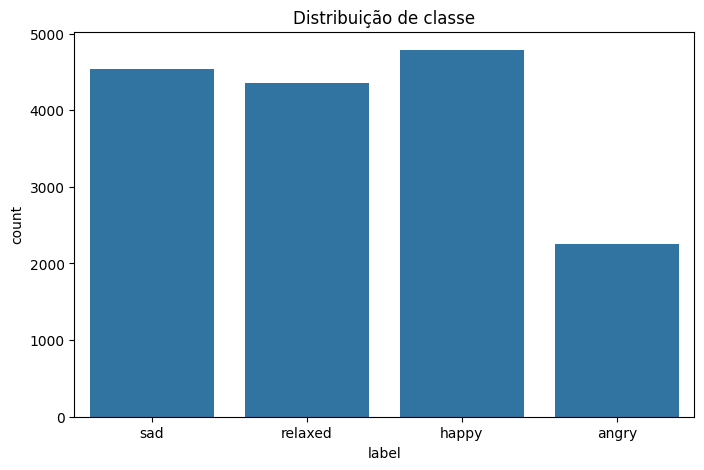

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

class_counts = df_dogs['label'].value_counts()
label_column = df_dogs.columns[-1]
plt.figure(figsize=(8,5))
sns.countplot(x=label_column, data=df_dogs)
plt.title("Distribuição de classe")
plt.show()

## 3.2 Correlação

Obs: Não é valido realizar a correlação após normalizar os dados, desse modo sera usado o dataset antes da normalização.

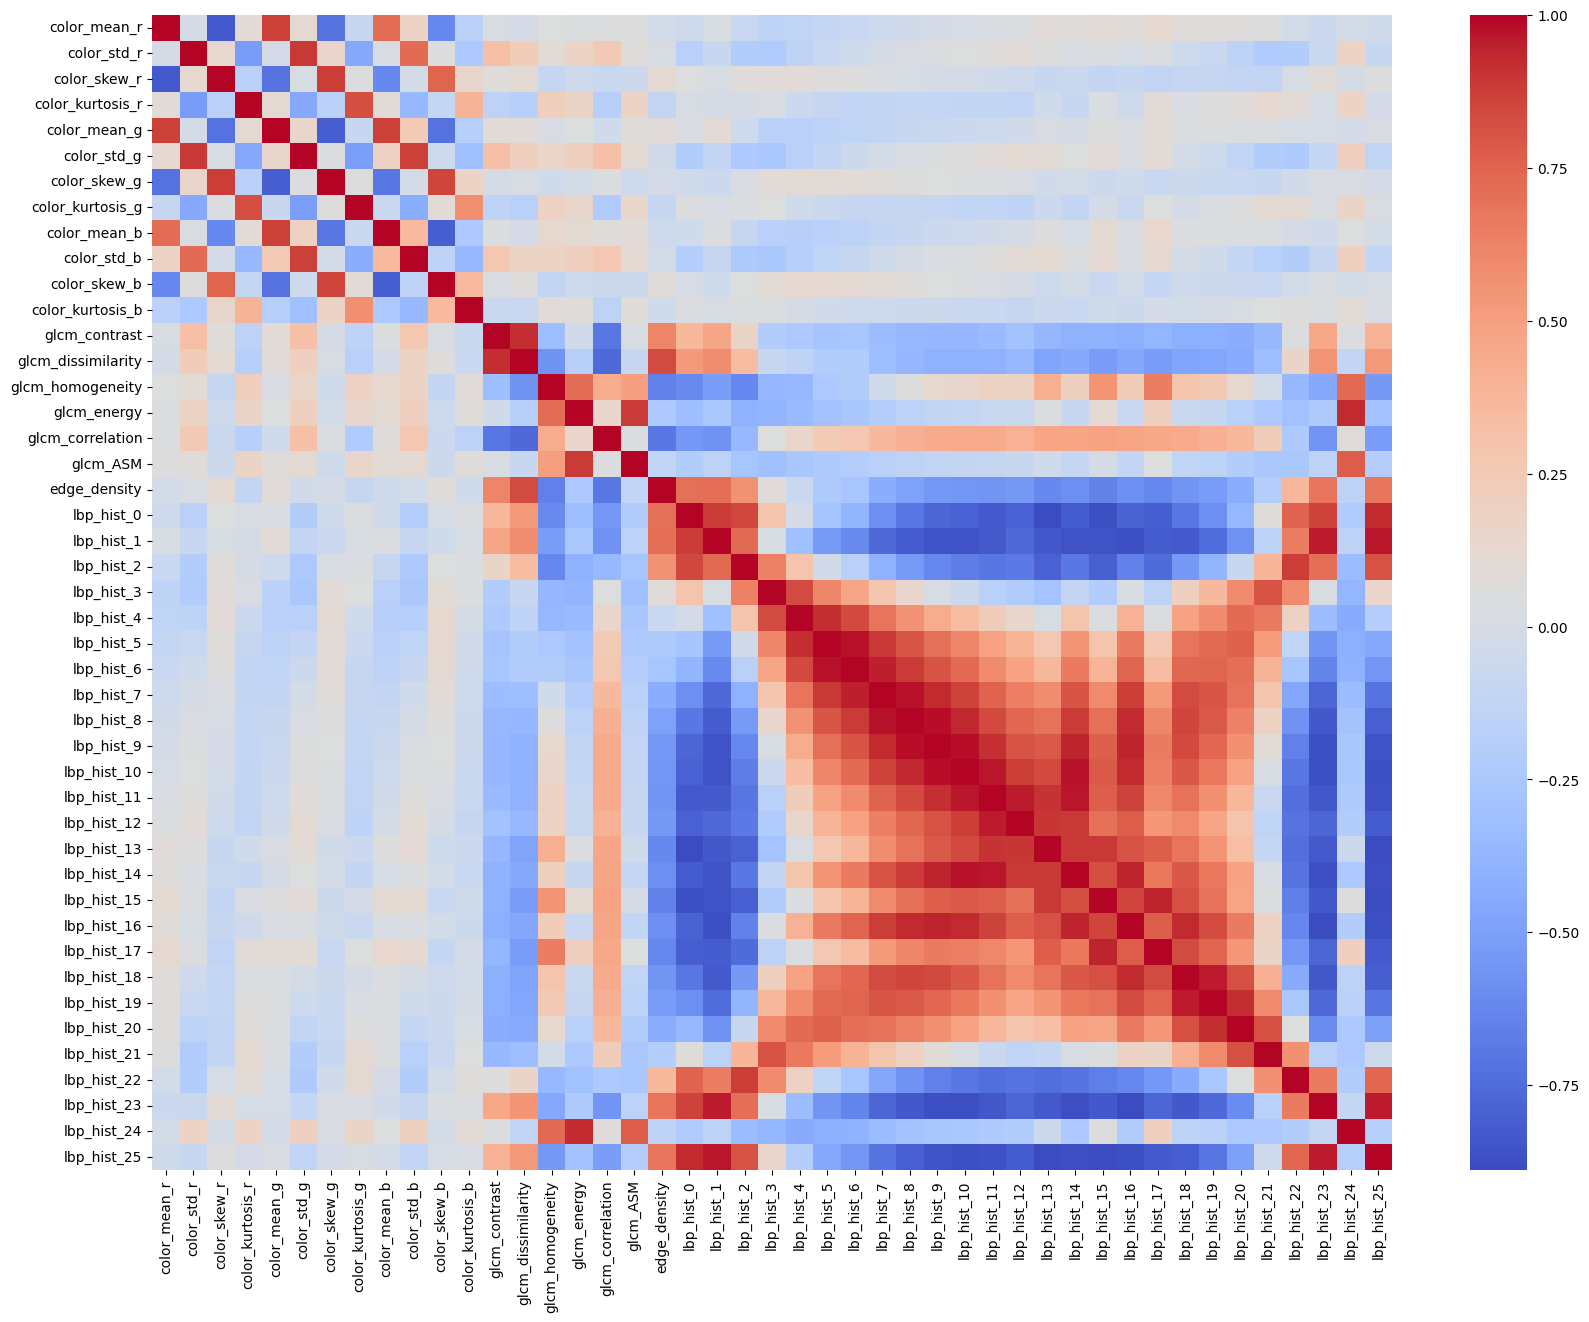

In [ ]:
df_dogs_numeric.corr()
matriz_correlacao = df_dogs_numeric.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(matriz_correlacao, cmap='coolwarm')
plt.show()

## 3.3 Distribuição das cores

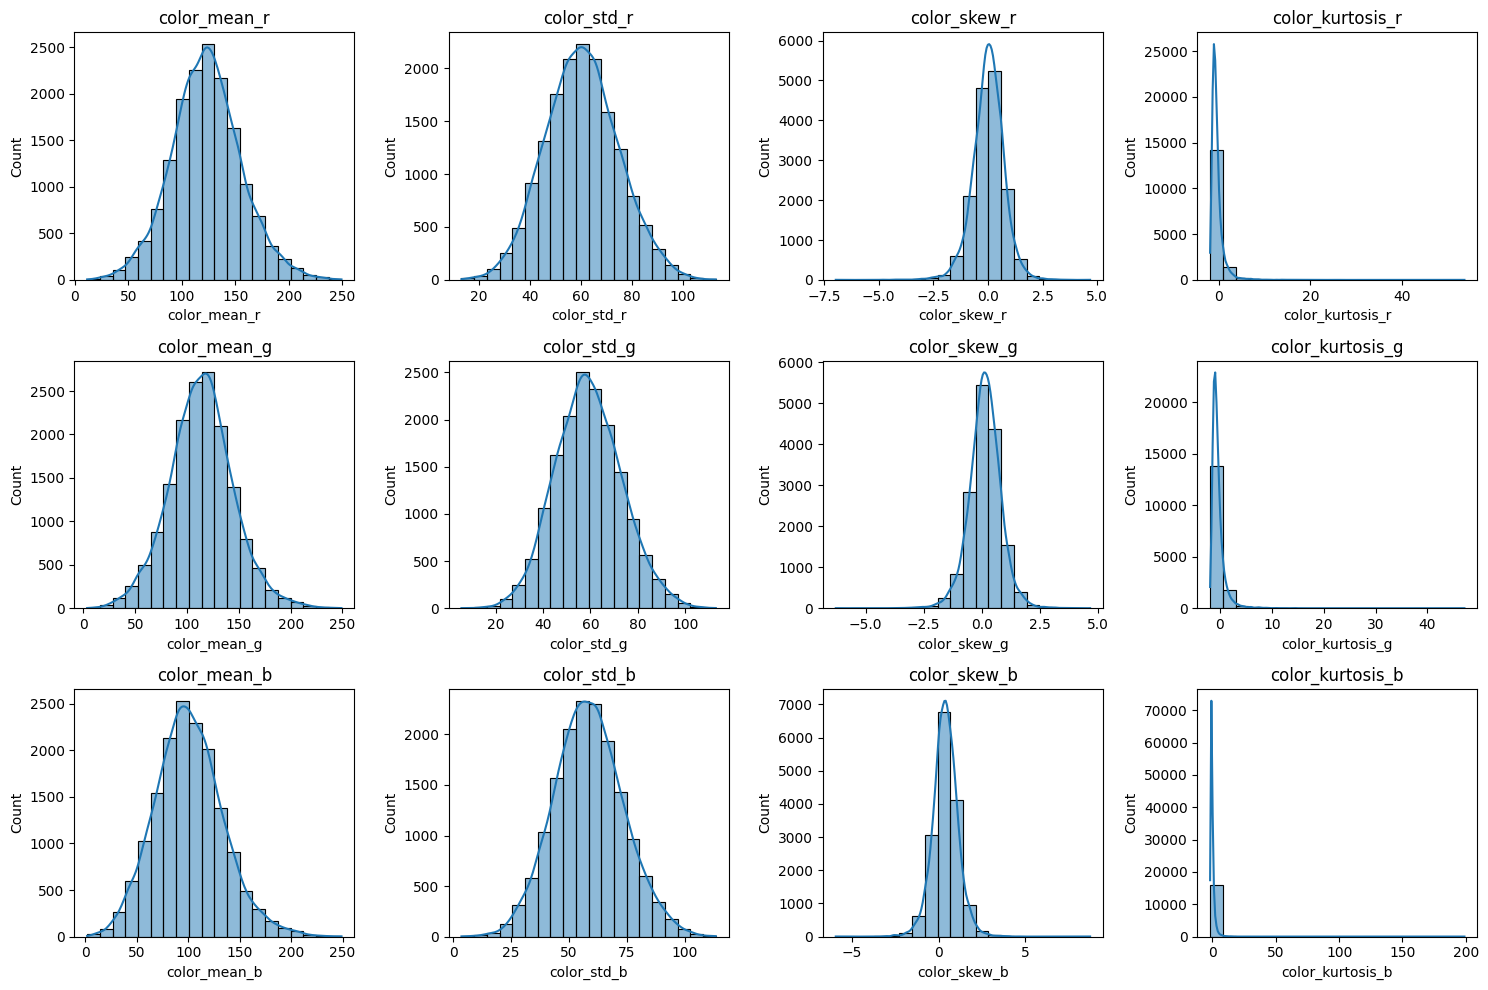

In [ ]:
features_to_plot = df_dogs.columns[:12]

plt.figure(figsize=(15, 10))
for i, col in enumerate(features_to_plot):
    plt.subplot(3, 4, i+1)
    sns.histplot(df_dogs[col], kde=True, bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

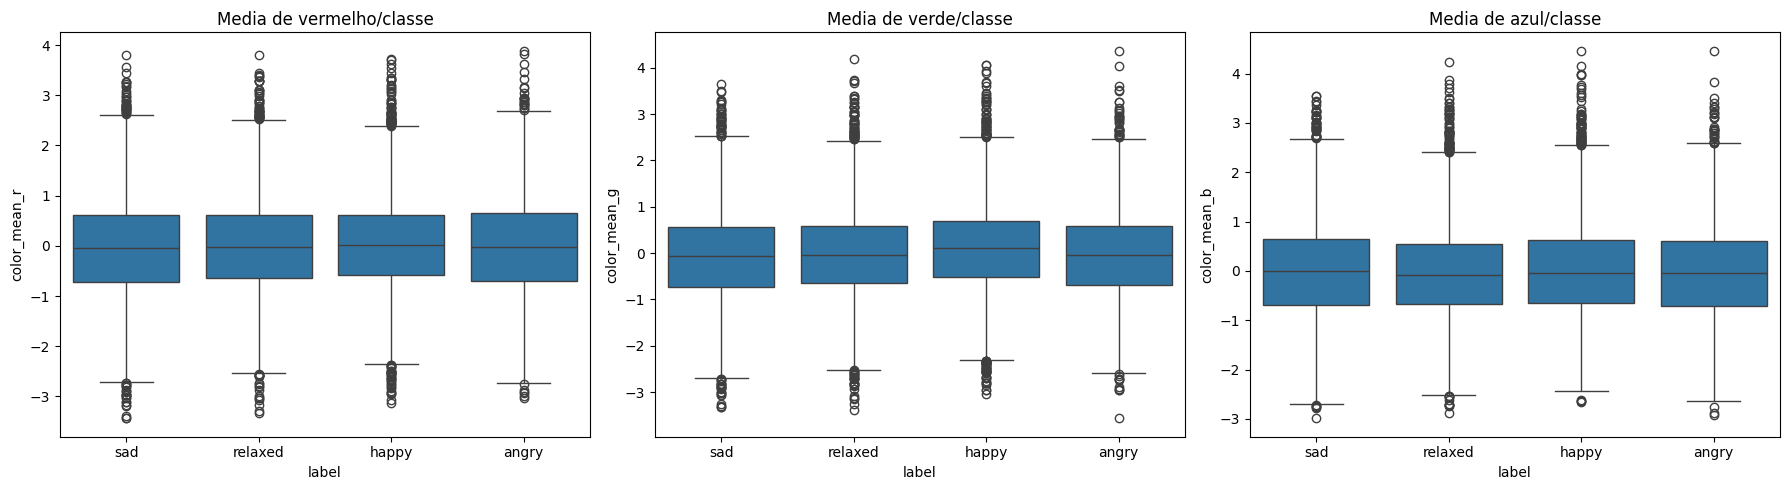

In [ ]:
plt.figure(figsize=(18,5))

# Red
plt.subplot(1, 3, 1)
sns.boxplot(x='label', y='color_mean_r', data=df_final_std)
plt.title('Media de vermelho/classe')

# Green
plt.subplot(1, 3, 2)
sns.boxplot(x='label', y='color_mean_g', data=df_final_std)
plt.title('Media de verde/classe')

# Blue
plt.subplot(1, 3, 3)
sns.boxplot(x='label', y='color_mean_b', data=df_final_std)
plt.title('Media de azul/classe')

plt.tight_layout()
plt.show()

## 3.4 Distribuição das classes a partir de pares de cores

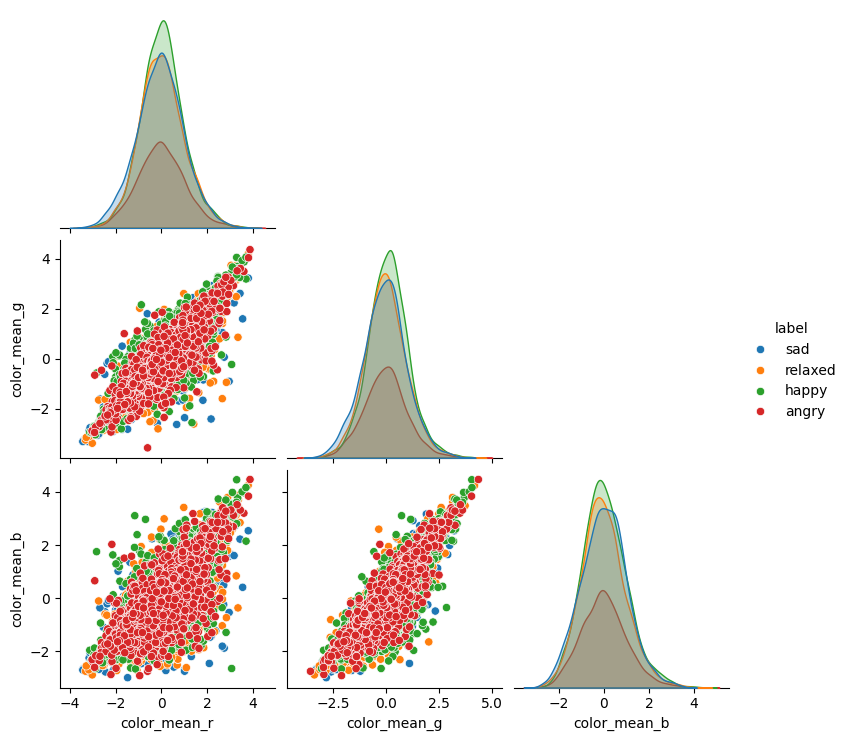

In [ ]:
sns.pairplot(df_final_std, vars=['color_mean_r','color_mean_g','color_mean_b'], hue='label', corner=True)
plt.show()

## 3.5 Importância de features

Forma simples de medir a importância de features baseado na dispersão entre classes.
Mede a diferença entre as classes baseado na feature em questão.

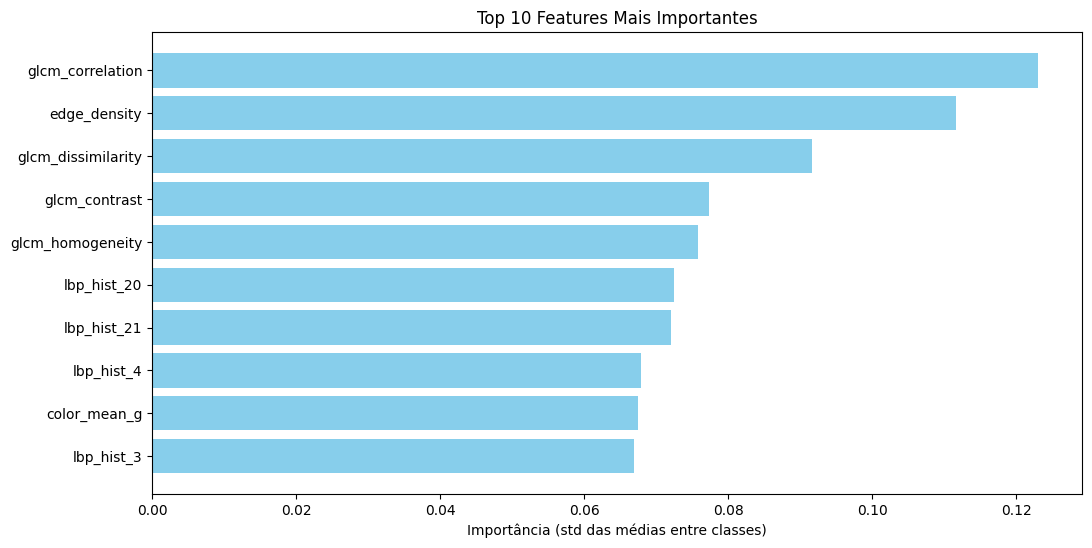

In [ ]:

labels = df_final_std['label'].unique()
feature_scores = {}
for col in df_dogs_scaled_standard.columns:
    values = [df_dogs_scaled_standard[df_final_std['label']==l][col].mean() for l in labels]
    feature_scores[col] = np.std(values)

sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)[:10]
features, scores = zip(*sorted_features[:10])  # top 10

plt.figure(figsize=(12,6))
plt.barh(features[::-1], scores[::-1], color='skyblue')
plt.xlabel('Importância (std das médias entre classes)')
plt.title('Top 10 Features Mais Importantes')
plt.show()

## 3.6 PCA

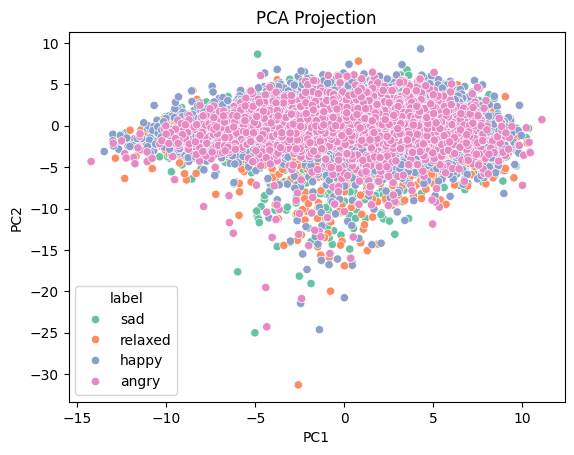

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_dogs_scaled_standard)  # only features
df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca['label'] = df_final_std['label']

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', palette='Set2')
plt.title('PCA Projection')
plt.show()

# 4 Algoritmo


## 4.1 Divisão dos dados

In [ ]:
splits = [
    {"name": "Conjunto de Teste Ideal", "random_state": 0, "test_size": 0.1, "unlabeled_frac": 0.25},
    {"name": "Conjunto de Teste Pequeno", "random_state": 42, "test_size": 0.1, "unlabeled_frac": 0.65},
    {"name": "Conjunto de Teste Medio", "random_state": 7,  "test_size": 0.2, "unlabeled_frac": 0.70},
    {"name": "Conjunto de Teste Grande", "random_state": 21, "test_size": 0.3, "unlabeled_frac": 0.75}
]

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_final_std['label'])
y_cnn_encoded = label_encoder.fit_transform(cnn_final['label'])
# y_labeled_encoded_test = pd.Series(
#     label_encoder.fit_transform(y_test),
#     index=y_test.index
# )

# y_labeled_encoded = pd.Series(
#     label_encoder.fit_transform(y_labeled),
#     index=y_labeled.index
# )

datasets = {
    "standard":df_final_std,
 #   "minmax": df_final_mm,
    "cnn": cnn_final
}

In [ ]:
data_division = []

for norm_name, df in datasets.items():
    X = df.drop('label', axis=1).to_numpy()  # features
    y = y_encoded  # same numeric labels

    for split in splits:
        # Train/test split
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X, y,
            test_size=split["test_size"],
            random_state=split["random_state"],
            stratify=y
        )

        # Labeled/unlabeled split
        X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
            X_train_full, y_train_full,
            test_size=split["unlabeled_frac"],
            random_state=split["random_state"],
            stratify=y_train_full
        )

        # Mark unlabeled
        y_unlabeled = np.full(len(y_unlabeled), -1)
        div = {
            "split_name": split['name'],
            norm_name :{
              "X_train": X_train_full,
              "X_test": X_test,
              "y_train_full": y_train_full,
              "y_test": y_test,
              "X_labeled": X_labeled,
              "X_unlabeled": X_unlabeled,
              "y_labeled": y_labeled,
              "y_unlabeled": y_unlabeled
            }
          }
        data_division.append(div)


        print(f"Done: Normalization={norm_name}, Split={split['name']}")

Done: Normalization=standard, Split=Conjunto de Teste Ideal
Done: Normalization=standard, Split=Conjunto de Teste Pequeno
Done: Normalization=standard, Split=Conjunto de Teste Medio
Done: Normalization=standard, Split=Conjunto de Teste Grande
Done: Normalization=cnn, Split=Conjunto de Teste Ideal
Done: Normalization=cnn, Split=Conjunto de Teste Pequeno
Done: Normalization=cnn, Split=Conjunto de Teste Medio
Done: Normalization=cnn, Split=Conjunto de Teste Grande


Separação simples, caso precise:

In [ ]:

#df_final_std
#df_final_mm
if('column_name' in df_dogs.columns):
  df_dogs = df_dogs.drop('filename', axis=1)

X = df_final_mm.drop('label', axis=1)
y = df_final_mm['label']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_train_full, y_train_full, test_size=0.65, random_state=42, stratify=y_train_full)

y_unlabeled = pd.Series([-1] * len(y_unlabeled), index=y_unlabeled.index)



In [ ]:
print("Total original data:", len(df_dogs))
print("X_train_full:", len(X_train_full)/len(df_dogs))
print("X_test:", len(X_test)/len(df_dogs))
print("X_labeled:", len(X_labeled)/len(df_dogs))
print("X_unlabeled:", len(X_unlabeled)/len(df_dogs))

Total original data: 15921
X_train_full: 0.7499528924062558
X_test: 0.2500471075937441
X_labeled: 0.2624835123421896
X_unlabeled: 0.4874693800640663


## 4.2 SelfTrainingClassifier + SVC


In [ ]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC

In [ ]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC # Você pode usar qualquer classificador de sua preferência

# 1. Crie o seu classificador base
# Um SVM é uma boa opção para muitas tarefas de classificação
base_classifier = SVC(probability=True, gamma='auto')

# 2. Crie o classificador semissupervisionado
self_training_model = SelfTrainingClassifier(base_classifier)

# 3. Combine os dados rotulados e não rotulados para o treinamento
results = []

for div in data_division:
    split_name = div['split_name']

    for norm_name, data in div.items():
        if norm_name == 'split_name':  # skip the key itself
            continue

        # Combine labeled + unlabeled
        X_train_semi = np.vstack([data["X_labeled"], data["X_unlabeled"]])
        y_train_semi = np.concatenate([data["y_labeled"], data["y_unlabeled"]])

        X_test = data["X_test"]
        y_test = data["y_test"]

        # Base classifier
        base_classifier = SVC(probability=True, gamma='auto')
        self_training_model = SelfTrainingClassifier(base_classifier)

        # Train
        self_training_model.fit(X_train_semi, y_train_semi)

        # Evaluate
        accuracy = self_training_model.score(X_test, y_test)
        print(f"Normalization={norm_name}, Split={split_name}, Accuracy={accuracy:.4f}")

        results.append({
            "normalization": norm_name,
            "split": split_name,
            "accuracy": accuracy
        })

# X_train_semi = pd.concat([X_labeled, X_unlabeled])
# y_train_semi = pd.concat([y_labeled, y_unlabeled])

# # 4. Treine o modelo
# # O SelfTrainingClassifier irá lidar com os rótulos -1 automaticamente
# self_training_model.fit(X_train_semi, y_train_semi)

# # 5. Avalie o desempenho no conjunto de teste que você reservou
# accuracy = self_training_model.score(X_test, y_test)
# print(f"Acurácia do modelo semissupervisionado: {accuracy}")

Normalization=standard, Split=Conjunto de Teste Ideal, Accuracy=0.3647
Normalization=standard, Split=Conjunto de Teste Pequeno, Accuracy=0.3729
Normalization=standard, Split=Conjunto de Teste Medio, Accuracy=0.3626
Normalization=standard, Split=Conjunto de Teste Grande, Accuracy=0.3550
Normalization=cnn, Split=Conjunto de Teste Ideal, Accuracy=0.3735
Normalization=cnn, Split=Conjunto de Teste Pequeno, Accuracy=0.3095
Normalization=cnn, Split=Conjunto de Teste Medio, Accuracy=0.3020
Normalization=cnn, Split=Conjunto de Teste Grande, Accuracy=0.3004


In [ ]:
summary_df = pd.DataFrame(results)
print(summary_df)

  normalization                      split  accuracy
0      standard    Conjunto de Teste Ideal  0.364721
1      standard  Conjunto de Teste Pequeno  0.372881
2      standard    Conjunto de Teste Medio  0.362637
3      standard   Conjunto de Teste Grande  0.355035
4           cnn    Conjunto de Teste Ideal  0.373509
5           cnn  Conjunto de Teste Pequeno  0.309479
6           cnn    Conjunto de Teste Medio  0.302041
7           cnn   Conjunto de Teste Grande  0.300398


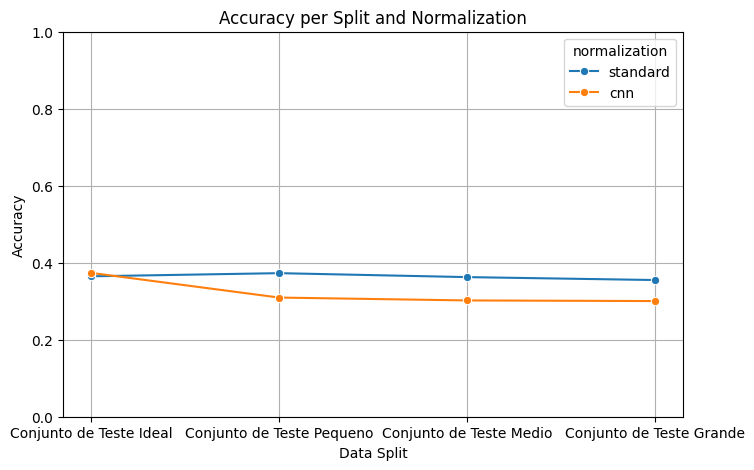

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

sns.lineplot(
    data=summary_df,
    x="split",
    y="accuracy",
    hue="normalization",
    marker="o"
)

plt.title("Accuracy per Split and Normalization")
plt.ylabel("Accuracy")
plt.xlabel("Data Split")
plt.ylim(0,1)
plt.grid(True)
plt.show()


Com isso da para concluir que a normalização não importa para esse caso, alem disso os melhores resultados, proximo de 40% ocorrem quando o conjunto de teste é 10% e apenas 35%
dos dados possuem rotulos

In [ ]:
data_division_filtered = []

for div in data_division:
    new_div = {"split_name": div["split_name"]}

    if "standard" in div:
      new_div["standard"] = div["standard"]
    if "cnn" in div:
      new_div["cnn"] = div["cnn"]

    data_division_filtered.append(new_div)

for div in data_division_filtered:
    split_name = div['split_name']

    for norm_name, data in div.items():
        if norm_name == 'split_name':  # skip the key itself
            continue
        print(f"Normalization={norm_name}, Split={split_name}")

Normalization=standard, Split=Conjunto de Teste Ideal
Normalization=standard, Split=Conjunto de Teste Pequeno
Normalization=standard, Split=Conjunto de Teste Medio
Normalization=standard, Split=Conjunto de Teste Grande
Normalization=cnn, Split=Conjunto de Teste Ideal
Normalization=cnn, Split=Conjunto de Teste Pequeno
Normalization=cnn, Split=Conjunto de Teste Medio
Normalization=cnn, Split=Conjunto de Teste Grande


### 4.2.1 Comparando bases para o SelfLearning

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
results_bases = []

classifiers = {'SVC' : SVC(probability=True, gamma='auto'),
               'DTree': DecisionTreeClassifier(random_state=0),
               'KNN-5': KNeighborsClassifier(n_neighbors=8)}
for div in data_division_filtered:
    split_name = div["split_name"]

    for norm_name, data in div.items():
        if norm_name == "split_name":
            continue

        # Combine labeled + unlabeled
        X_train_semi = np.vstack([data["X_labeled"], data["X_unlabeled"]])
        y_train_semi = np.concatenate([data["y_labeled"], data["y_unlabeled"]])

        X_test = data["X_test"]
        y_test = data["y_test"]

        for clf_name, base_clf in classifiers.items():
            self_training_model = SelfTrainingClassifier(base_clf)

            # Train
            self_training_model.fit(X_train_semi, y_train_semi)

            # Evaluate
            accuracy = self_training_model.score(X_test, y_test)

            # Save results
            results_bases.append({
                "split": split_name,
                "normalization": norm_name,
                "classifier": clf_name,
                "accuracy": accuracy
            })

            print(f"Done: {norm_name}, {split_name}, {clf_name}, Accuracy={accuracy:.4f}")

Done: standard, Conjunto de Teste Ideal, SVC, Accuracy=0.3647
Done: standard, Conjunto de Teste Ideal, DTree, Accuracy=0.2793
Done: standard, Conjunto de Teste Ideal, KNN-5, Accuracy=0.2976
Done: standard, Conjunto de Teste Pequeno, SVC, Accuracy=0.3729
Done: standard, Conjunto de Teste Pequeno, DTree, Accuracy=0.2611
Done: standard, Conjunto de Teste Pequeno, KNN-5, Accuracy=0.3183
Done: standard, Conjunto de Teste Medio, SVC, Accuracy=0.3626
Done: standard, Conjunto de Teste Medio, DTree, Accuracy=0.2807
Done: standard, Conjunto de Teste Medio, KNN-5, Accuracy=0.3146
Done: standard, Conjunto de Teste Grande, SVC, Accuracy=0.3550
Done: standard, Conjunto de Teste Grande, DTree, Accuracy=0.2966
Done: standard, Conjunto de Teste Grande, KNN-5, Accuracy=0.2979
Done: cnn, Conjunto de Teste Ideal, SVC, Accuracy=0.3735
Done: cnn, Conjunto de Teste Ideal, DTree, Accuracy=0.3045
Done: cnn, Conjunto de Teste Ideal, KNN-5, Accuracy=0.3302
Done: cnn, Conjunto de Teste Pequeno, SVC, Accuracy=0.30

In [ ]:
summary_df = pd.DataFrame(results_bases)
print(summary_df)

                        split normalization classifier  accuracy
0     Conjunto de Teste Ideal      standard        SVC  0.364721
1     Conjunto de Teste Ideal      standard      DTree  0.279347
2     Conjunto de Teste Ideal      standard      KNN-5  0.297552
3   Conjunto de Teste Pequeno      standard        SVC  0.372881
4   Conjunto de Teste Pequeno      standard      DTree  0.261142
5   Conjunto de Teste Pequeno      standard      KNN-5  0.318267
6     Conjunto de Teste Medio      standard        SVC  0.362637
7     Conjunto de Teste Medio      standard      DTree  0.280691
8     Conjunto de Teste Medio      standard      KNN-5  0.314600
9    Conjunto de Teste Grande      standard        SVC  0.355035
10   Conjunto de Teste Grande      standard      DTree  0.296630
11   Conjunto de Teste Grande      standard      KNN-5  0.297886
12    Conjunto de Teste Ideal           cnn        SVC  0.373509
13    Conjunto de Teste Ideal           cnn      DTree  0.304457
14    Conjunto de Teste I

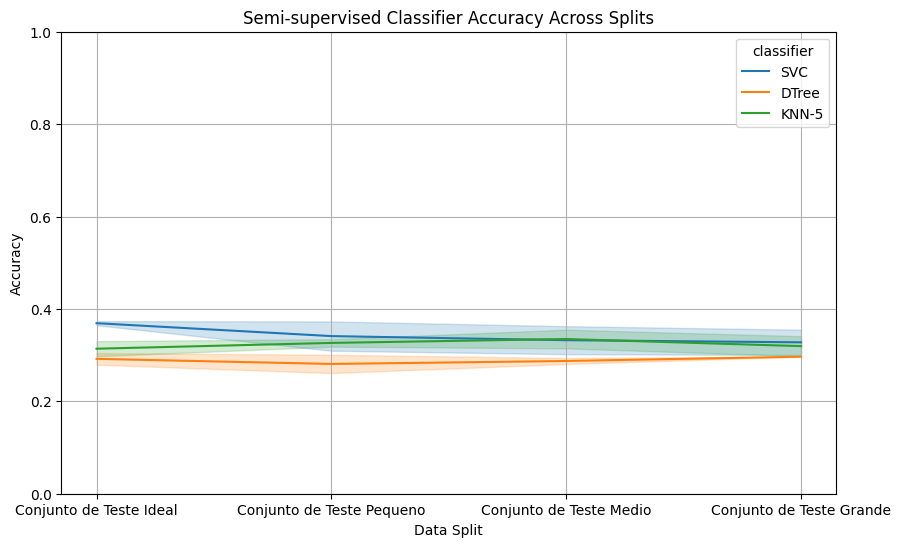

In [ ]:

plt.figure(figsize=(10,6))

sns.lineplot(
    data=summary_df,
    x="split",
    y="accuracy",
    hue="classifier",
    markers=True,
    dashes=False
)

plt.title("Semi-supervised Classifier Accuracy Across Splits")
plt.ylabel("Accuracy")
plt.xlabel("Data Split")
plt.ylim(0,1)
plt.grid(True)
plt.show()

## 4.3 Label Propagation

In [ ]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import accuracy_score
# lp = LabelPropagation()

# X_train_semi = pd.concat([X_labeled, X_unlabeled])
# y_train_semi = pd.concat([y_labeled_encoded, y_unlabeled])

# lp.fit(X_train_semi, y_train_semi)

lp_results = []

for div in data_division_filtered:
    split_name = div["split_name"]

    for norm_name, data in div.items():
        if norm_name == "split_name":
            continue

        # Combine labeled + unlabeled
        X_train_semi = np.vstack([data["X_labeled"], data["X_unlabeled"]])
        y_train_semi = np.concatenate([data["y_labeled"], data["y_unlabeled"]])

        X_test = data["X_test"]
        y_test = data["y_test"]

        # Train LabelPropagation
        lp = LabelPropagation()
        lp.fit(X_train_semi, y_train_semi)

        # Predict on test
        y_pred = lp.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        lp_results.append({
            "split": split_name,
            "normalization": norm_name,
            "classifier": "LabelPropagation",
            "accuracy": acc
        })

        print(f"Done: {norm_name}, {split_name}, LabelPropagation, Accuracy={acc:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Done: standard, Conjunto de Teste Ideal, LabelPropagation, Accuracy=0.2881


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Done: standard, Conjunto de Teste Pequeno, LabelPropagation, Accuracy=0.2888


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Done: standard, Conjunto de Teste Medio, LabelPropagation, Accuracy=0.2863


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Done: standard, Conjunto de Teste Grande, LabelPropagation, Accuracy=0.2818
Done: cnn, Conjunto de Teste Ideal, LabelPropagation, Accuracy=0.3308
Done: cnn, Conjunto de Teste Pequeno, LabelPropagation, Accuracy=0.3258
Done: cnn, Conjunto de Teste Medio, LabelPropagation, Accuracy=0.3297


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


Done: cnn, Conjunto de Teste Grande, LabelPropagation, Accuracy=0.3119


In [ ]:
lp_df = pd.DataFrame(lp_results)

## 4.4 Label Spreading

In [ ]:
from sklearn.semi_supervised import LabelSpreading

ls_results = []

label_spreading_model = LabelSpreading(kernel='rbf', gamma=0.0009, alpha=0.9, max_iter=300)

for div in data_division_filtered:
    split_name = div["split_name"]

    for norm_name, data in div.items():
        if norm_name == "split_name":
            continue

        # Combine labeled + unlabeled
        X_train_semi = np.vstack([data["X_labeled"], data["X_unlabeled"]])
        y_train_semi = np.concatenate([data["y_labeled"], data["y_unlabeled"]])

        X_test = data["X_test"]
        y_test = data["y_test"]

        # Train LabelPropagation
        ls = label_spreading_model
        ls.fit(X_train_semi, y_train_semi)

        # Predict on test
        y_pred = ls.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        ls_results.append({
            "split": split_name,
            "normalization": norm_name,
            "classifier": "LabelSpreading",
            "accuracy": acc
        })

        print(f"Done: {norm_name}, {split_name}, LabelSpreading, Accuracy={acc:.4f}")

Done: standard, Conjunto de Teste Ideal, LabelSpreading, Accuracy=0.3007
Done: standard, Conjunto de Teste Pequeno, LabelSpreading, Accuracy=0.3007
Done: standard, Conjunto de Teste Medio, LabelSpreading, Accuracy=0.3005
Done: standard, Conjunto de Teste Grande, LabelSpreading, Accuracy=0.3004
Done: cnn, Conjunto de Teste Ideal, LabelSpreading, Accuracy=0.3007
Done: cnn, Conjunto de Teste Pequeno, LabelSpreading, Accuracy=0.3007
Done: cnn, Conjunto de Teste Medio, LabelSpreading, Accuracy=0.3005
Done: cnn, Conjunto de Teste Grande, LabelSpreading, Accuracy=0.3004


In [ ]:
ls_df = pd.DataFrame(ls_results)

In [ ]:
all_results_df = pd.concat([summary_df, lp_df, ls_df], ignore_index=True)

# 5 Comparando todos resultados

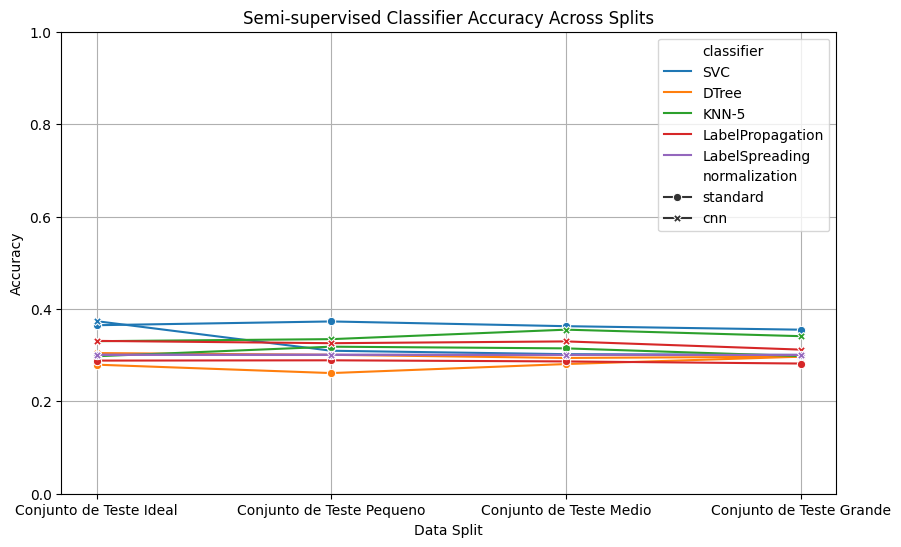

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

sns.lineplot(
    data=all_results_df,
    x="split",
    y="accuracy",
    hue="classifier",
    style="normalization",
    markers=True,
    dashes=False
)

plt.title("Semi-supervised Classifier Accuracy Across Splits")
plt.ylabel("Accuracy")
plt.xlabel("Data Split")
plt.ylim(0,1)
plt.grid(True)
plt.show()




---


# Teste com distribuição 90% dos dados rotulados


---



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assumindo que seu DataFrame 'df_dogs_cnn' já está carregado
# df_dogs_cnn = pd.read_csv(csv_output_path_cnn)

# 1. Separar as features (X) e os rótulos (y)
X = df_dogs__cnn_numeric
y_original = df_dogs_cnn['label']

# 2. É uma boa prática converter os rótulos de texto para números
le = LabelEncoder()
y = le.fit_transform(y_original)

# 3. Criar um conjunto de treino e um conjunto de teste final (held-out)
# Este X_test e y_test será usado apenas para a avaliação final.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% dos dados para o teste final
    random_state=0,      # Para reprodutibilidade
    stratify=y            # Mantém a proporção das classes nos splits
)

# 4. Simular o cenário semissupervisionado no conjunto de TREINO
# Vamos usar apenas 10% dos dados de treino como rotulados.
# Os outros 90% terão seus rótulos substituídos por -1.

# Copiamos os rótulos de treino para um novo array
y_train_semi = np.copy(y_train)

# Embaralhamos os índices para escolher aleatoriamente quais rótulos esconder
rng = np.random.RandomState(0)
random_unlabeled_points = rng.rand(len(y_train)) < 0.05 # 90% serão não rotulados

# Substituímos os rótulos dos índices escolhidos por -1
y_train_semi[random_unlabeled_points] = -1

# Verificar quantos rótulos temos
n_labeled = np.sum(y_train_semi != -1)
n_unlabeled = np.sum(y_train_semi == -1)
print(f"Dados de treino rotulados: {n_labeled}")
print(f"Dados de treino não rotulados: {n_unlabeled}")

Dados de treino rotulados: 12067
Dados de treino não rotulados: 669


Treinando o modelo Label Spreading...
Treinamento concluído.

Acurácia do modelo Semissupervisionado (Label Spreading): 45.93%

Relatório de Classificação:
              precision    recall  f1-score   support

       angry       0.56      0.07      0.12       451
       happy       0.49      0.63      0.55       957
     relaxed       0.50      0.21      0.30       870
         sad       0.42      0.71      0.53       907

    accuracy                           0.46      3185
   macro avg       0.49      0.41      0.38      3185
weighted avg       0.48      0.46      0.42      3185



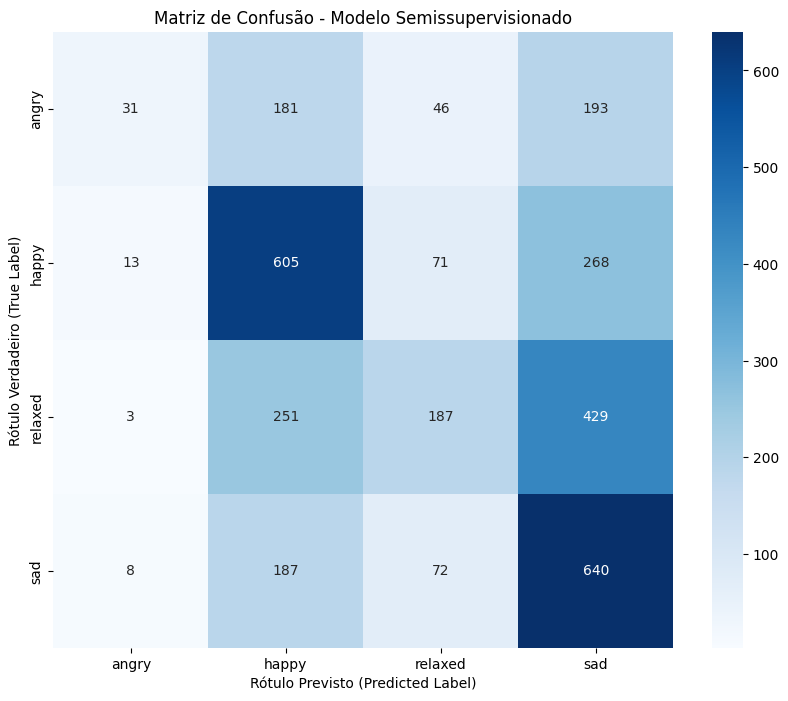

In [ ]:
from sklearn.semi_supervised import LabelSpreading


label_spreading_model = LabelSpreading(kernel='rbf', gamma=0.0009, alpha=0.9, max_iter=300)

print("Treinando o modelo Label Spreading...")
label_spreading_model.fit(X_train, y_train_semi)
print("Treinamento concluído.")

y_pred_ss = label_spreading_model.predict(X_test)

accuracy_ss = accuracy_score(y_test, y_pred_ss)
print(f"\nAcurácia do modelo Semissupervisionado (Label Spreading): {accuracy_ss * 100:.2f}%\n")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_ss, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_ss)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Matriz de Confusão - Modelo Semissupervisionado')
plt.ylabel('Rótulo Verdadeiro (True Label)')
plt.xlabel('Rótulo Previsto (Predicted Label)')

plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


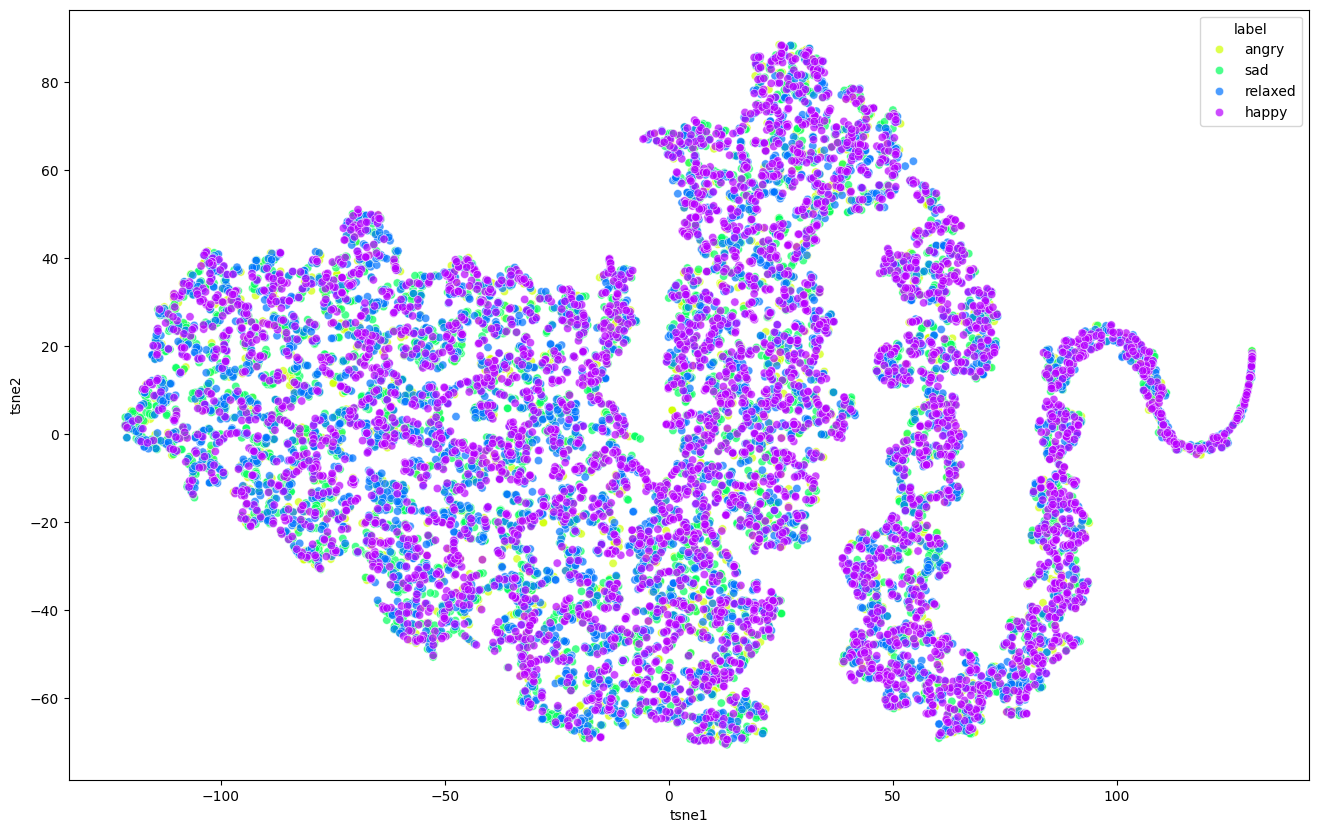

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(df_dogs_numeric)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne['label'] = y_original

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="label",
    palette=sns.color_palette("hsv", len(df_tsne['label'].unique())),
    data=df_tsne,
    legend="full",
    alpha=0.7
)
plt.show()

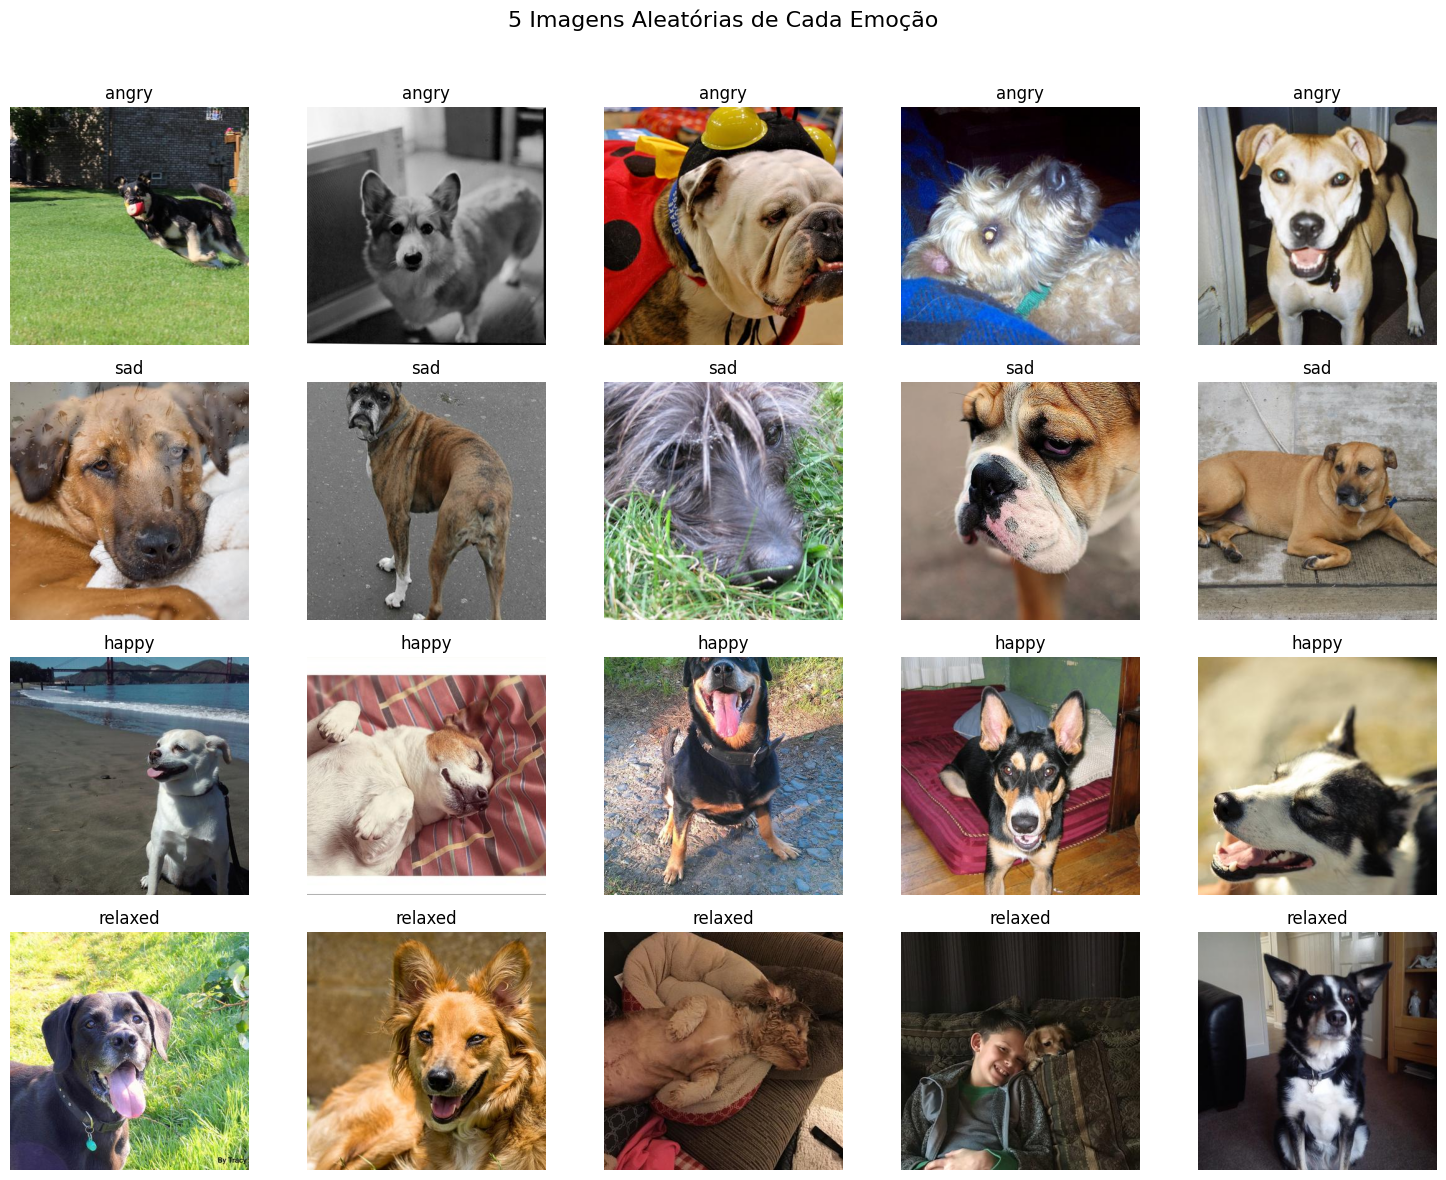

In [ ]:
from PIL import Image
import random

target_folders = ['angry', 'sad', 'happy', 'relaxed']

fig, axes = plt.subplots(len(target_folders), 5, figsize=(15, 12))

fig.suptitle('5 Imagens Aleatórias de Cada Emoção', fontsize=16)

for i, folder_name in enumerate(target_folders):
    emotion_path = os.path.join(folder_path, folder_name)
    if os.path.isdir(emotion_path):
        all_images = [f for f in os.listdir(emotion_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        random_images_sample = random.sample(all_images, min(5, len(all_images)))

        for j, image_filename in enumerate(random_images_sample):
            image_path = os.path.join(emotion_path, image_filename)

            try:
                img = Image.open(image_path)

                ax = axes[i, j]
                ax.imshow(img)
                ax.set_title(folder_name)
                ax.axis('off')
            except Exception as e:
                print(f"Não foi possível carregar a imagem {image_path}: {e}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()